In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from pylab import plt, mpl
from sklearn.linear_model import Ridge, Lasso
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed, uniform
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import math
import seaborn as sns
from sklearn.model_selection import validation_curve
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
plt.rcParams['figure.figsize'] = [10, 5]

In [188]:
#Produce the data points according to frank function and add error to the points
def FrankeFunction(n_pts):
    global x
    global y
    x = np.arange(0, 1, 1/math.sqrt(n_pts))
    y = np.arange(0, 1, 1/math.sqrt(n_pts))
    x, y = np.meshgrid(x,y)
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + np.random.normal(0, 0.1,x.shape)
z = FrankeFunction(400)

#Define the fitting function
def polyfit(train,test,target,target_test,degree,model):
    #Produce the design matrix
    poly = PolynomialFeatures(degree)
    X1_train=poly.fit_transform(train)
    X1_test=poly.fit_transform(test)
    #Fitting the model
    model.fit(X1_train,target)
    ypredictR = model.predict(X1_train)
    ypredictRtest = model.predict(X1_test)
    return ypredictR,ypredictRtest

#define the score function to get the R2 score and the MSE for the function    
def score(train,test,target,target_test,degree,model):
    ypredictR,ypredictRtest=polyfit(train,test,target,target_test,degree,model)
    return r2_score(target, ypredictR),mean_squared_error(target, ypredictR),r2_score(target_test, ypredictRtest),mean_squared_error(target_test, ypredictRtest)

#define the bootstrap function to fit the data with bootstraps resampling 
def bootstrap(XY_train,XY_test,z_train,z_test,degree,alpha,n_bootstraps):
    y_pred = np.empty((z_test.shape[0], n_bootstraps))
    R=Ridge(alpha)
    #Define Model
    #R=LinearRegression()
    #Produce the design matrix
    poly = PolynomialFeatures(degree)
    X1_train=poly.fit_transform(XY_train)
    X1_test=poly.fit_transform(XY_test)
    #bootstraping the data points and fitting the model
    for j in range(n_bootstraps):
        x_, y_ = resample(X1_train, z_train)
        y_=y_.reshape(-1,1)
        y_pred[:, j] = R.fit(x_, y_).predict(X1_test).ravel()
    bootstraps=np.mean(y_pred, axis=1, keepdims=True)
    bootstraps=bootstraps.reshape(-1)
    #Saving the results of the bootstrap
    bias = np.mean( (z_test - bootstraps)**2 )
    variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    return bias,variance
    

In [60]:
degree=5
#preparing the data points for the fitting
z = z.flatten()
XY=np.zeros((len(x.flatten()),2))
XY[:,0]=x.flatten()
XY[:,1]=y.flatten()
#split the data points into a train set and test set
XY_train, XY_test, z_train, z_test = train_test_split(XY,z,test_size=0.19)
z_train=z_train.flatten()

#Fitting the data points using make_pipeline to get the beta values
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(XY_train,z_train)
zpredictR = polyreg.predict(XY_train)
zpredictRtest = polyreg.predict(XY_test)
ridge=polyreg.named_steps['linearregression']
beta= ridge.coef_

#producing the design matrix
poly = PolynomialFeatures(degree)
X=poly.fit_transform(XY_train)
betan=poly.get_feature_names()

#calculating the variance of the beta values
var=0.1*0.1*np.linalg.inv(X.T@X)
u=np.zeros(len(var.diagonal()))
for i in range(len(var.diagonal())):
    u[i]=i

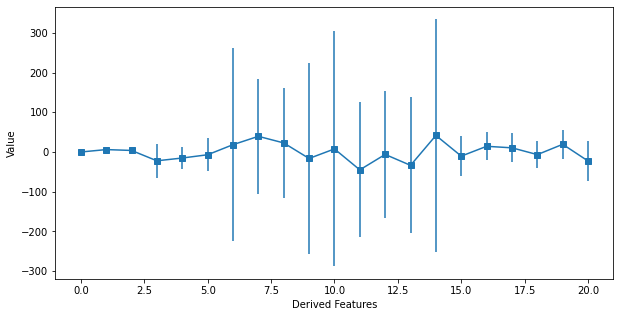

In [146]:
#plot the variance of the beta values
plt.errorbar(u, beta,yerr=1.96*var.diagonal(),marker='s')
#plt.yscale('log')
plt.xlabel(r'Derived Features')
plt.ylabel(r'Value')
plt.show()


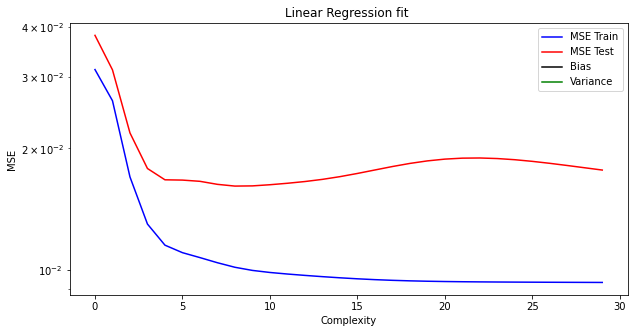

In [218]:
maxdegree=30
bias=np.zeros(maxdegree)
variance=np.zeros(maxdegree)
mse_train=np.zeros((maxdegree))
r2_train=np.zeros((maxdegree))
r2_test=np.zeros((maxdegree))
mse_test=np.zeros((maxdegree))
p1=np.arange(maxdegree)
#fitting and bootstraping from degree 1 to maxdegree
for i in range(maxdegree):
    #bias[i],variance[i] = bootstrap(XY_train,XY_test,z_train,z_test,degree=i+1,alpha=0.001,n_bootstraps=400)
    #model=LinearRegression()
    model=Ridge(0.0001)
    r2_train[i],mse_train[i],r2_test[i],mse_test[i]=score(XY_train,XY_test,z_train,z_test,degree=i+1,model=model)
#plotting the MSE, Bias and the variance of the fit 
plt.plot(p1,mse_train,'b-',label='MSE Train')
plt.plot(p1,mse_test, 'r-',label='MSE Test')
plt.plot(p1,bias, 'k-',label='Bias')
plt.plot(p1,variance, 'g-',label='Variance')
#plt.plot(p1,mse_train,'b-')
#plt.plot(p1,mse_test, 'r-')
#plt.plot(p1,bias, 'k-')
#plt.plot(p1,variance, 'g-')
plt.yscale('log')
plt.xlabel(r'Complexity')
plt.ylabel(r'MSE')
plt.title(r'Linear Regression fit ')
plt.legend()
plt.show()

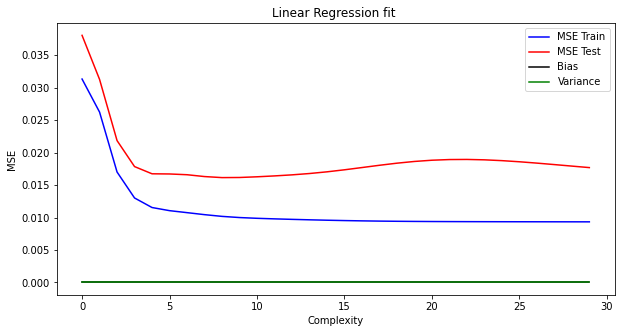

In [219]:
#plt.plot(p1,mse_train,'b-')
#plt.plot(p1,mse_test, 'r-')
plt.plot(p1,mse_train,'b-',label='MSE Train')
plt.plot(p1,mse_test, 'r-',label='MSE Test')
plt.plot(p1,bias, 'k-',label='Bias')
plt.plot(p1,variance, 'g-',label='Variance')
#plt.yscale('log')
plt.xlabel(r'Complexity')
plt.ylabel(r'MSE')
plt.title(r'Linear Regression fit ')
plt.legend()
plt.show()

In [220]:
print(r2_train[4],mse_train[4],r2_test[4],mse_test[4]) #print cost function for 5th order polynomial

0.86362831142307 0.011538242963024085 0.8233162312206102 0.01673269139414497


In [225]:
#function to study cross validation MSE as a function of the number of folds
trainLR=np.zeros((maxdegree))
testLR=np.zeros((maxdegree))
maxFolds = 10
c1=np.arange(maxdegree)
k1 = np.zeros((maxFolds,maxdegree))
#loop over number of folds 
for k in range(maxFolds-5):
    kfold = KFold(n_splits = k+5)
#loop over complexity values 
    for i in range(maxdegree):
            c1[i]=i
            polyreg=PolynomialFeatures(i+1)
            #model=LinearRegression()
            model=Ridge(0.0001)
            XY1_train=polyreg.fit_transform(XY_train)
            #use SciKit_learn Functionality to calculate Cross Validation Score
            LR_estimated_mse_folds = cross_val_score(model, XY1_train, z_train, scoring='neg_mean_squared_error', cv=kfold)
            testLR[i]=np.mean(-LR_estimated_mse_folds)
            k1[k,i] = testLR[i]
    
print(k1)  

[[0.03184485 0.0268976  0.01808182 0.0142539  0.01317629 0.01269723
  0.01245176 0.01226    0.01209929 0.01199449 0.01193259 0.01188576
  0.01183987 0.0117935  0.01174987 0.01171247 0.01168387 0.01166553
  0.01165797 0.01166088 0.01167345 0.01169455 0.01172298 0.01175763
  0.01179758 0.01184215 0.0118909  0.01194359 0.01200015 0.01206065]
 [0.03167541 0.02697201 0.0181968  0.01451681 0.01307887 0.01255731
  0.01229714 0.0120699  0.01186004 0.01171846 0.01163946 0.01158802
  0.01154194 0.01149618 0.0114534  0.01141744 0.0113911  0.01137588
  0.01137231 0.01138023 0.01139909 0.01142814 0.01146662 0.01151385
  0.01156929 0.01163255 0.01170334 0.01178145 0.01186668 0.01195879]
 [0.03194277 0.02707268 0.01844911 0.01454508 0.01313283 0.01262494
  0.01239863 0.01224106 0.0121256  0.01206792 0.01204606 0.01202993
  0.01200716 0.01197928 0.01195235 0.01193175 0.01192077 0.01192067
  0.01193127 0.01195148 0.01197978 0.01201445 0.01205379 0.01209623
  0.01214034 0.0121849  0.01222887 0.01227146 

In [226]:
k1[3,4]

0.013049300075645547

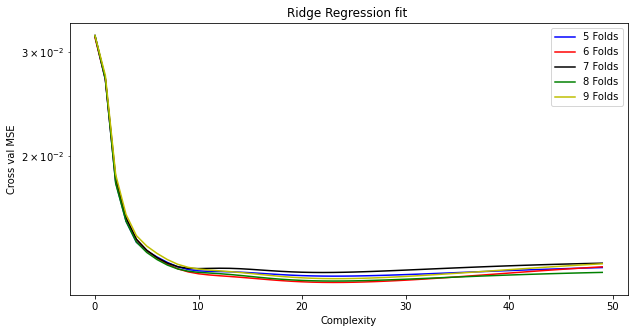

In [187]:
#plot crooss validation MSE
plt.plot(c1,k1[0,:],'b-',label='5 Folds')
plt.plot(c1,k1[1,:], 'r-',label='6 Folds')
plt.plot(c1,k1[2,:], 'k-',label='7 Folds')
plt.plot(c1,k1[3,:], 'g-',label='8 Folds')
plt.plot(c1,k1[4,:], 'y-',label='9 Folds')

#plt.axis([0,30,0, 0.9])
plt.yscale('log')
plt.xlabel(r'Complexity')
plt.ylabel(r'Cross val MSE')
plt.title(r'Ridge Regression fit ')
plt.legend()
plt.show()
# We have to explain why the mse diverges in linear regression

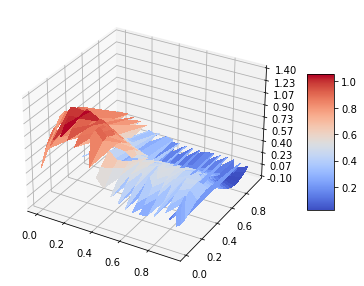

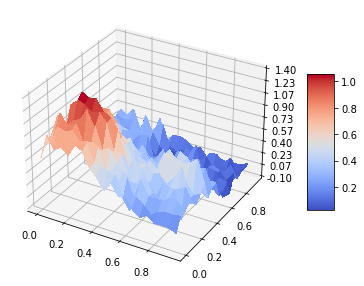

In [8]:
#Sorting the fitted data to visualize it
XYZ=np.zeros((len(XY_train),3))
XYZ[:,0]=XY_train[:,0]
XYZ[:,1]=XY_train[:,1]
XYZ[:,2]=zpredictR
XYZ=XYZ[np.lexsort((XYZ[:, 1], XYZ[:, 0]))]

#Return the data to the grid shape for visualizing
z1=XYZ[:,2]
z1=z1.reshape(18,18)
z=z.reshape(20,20)
x1=XYZ[:,0]
x1=x1.reshape(18,18)
y1=XYZ[:,1]
y1=y1.reshape(18,18)

#3D plot to visulaize the original data and the fitted data
fig = plt.figure()
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(x1, y1, z1, cmap=cm.coolwarm,
linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=0.5, aspect=5)
plt.show()
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=0.5, aspect=5)
plt.show()

0.017448199986991632
0.017442867356683545
0.0173920600079467
0.017059012504739245
0.01673269139414497
0.017290241519644554
0.020639280011292022
0.024611143537350402
0.03023616654805193
0.03768832087580842
0.05339712928127302
0.08268790142511433
0.09327499452305969
0.09459261443290164
0.09472754756783379
0.09474107329800938
0.09474242619591382


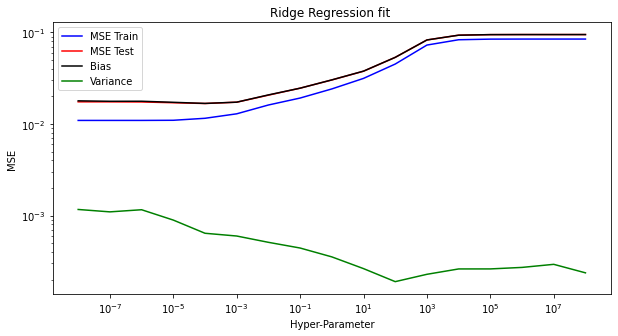

In [165]:
stop = 8
folds=5
start=8
tot=start+stop+1        
val=np.logspace(-start,stop,num=tot)
bias=np.zeros(tot)
variance=np.zeros(tot)
mse_train=np.zeros((tot))
r2_train=np.zeros((tot))
r2_test=np.zeros((tot))
mse_test=np.zeros((tot))
ind=np.zeros((tot))
p1=np.arange(tot)
#Loop over hyperparameter values complexity set to 5
for i in range(tot):
    #calculate bias variance
    bias[i],variance[i] = bootstrap(XY_train,XY_test,z_train,z_test,degree=5,alpha=val[i],n_bootstraps=400)
    model=Ridge(val[i])
    ind[i]=i
    #calculate cost functions
    r2_train[i],mse_train[i],r2_test[i],mse_test[i]=score(XY_train,XY_test,z_train,z_test,degree=5,model=model)
    print(mse_test[i])
#plotting the MSE, Bias and the variance of the fit 
plt.plot(val,mse_train,'b-',label='MSE Train')
plt.plot(val,mse_test, 'r-',label='MSE Test')
plt.plot(val,bias, 'k-',label='Bias')
plt.plot(val,variance, 'g-',label='Variance')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Hyper-Parameter')
plt.ylabel(r'MSE')
plt.title(r'Ridge Regression fit ')
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

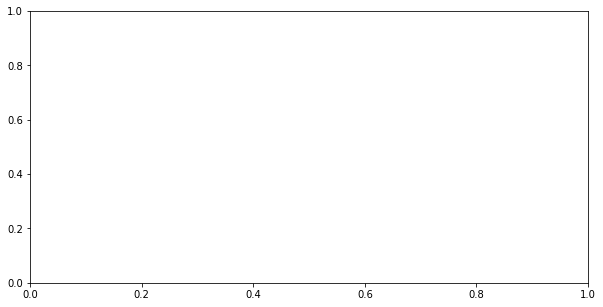

In [160]:
plt.plot(val,mse_train,'b-',label='MSE Train')
plt.plot(val,mse_test, 'r-',label='MSE Test')
plt.plot(val,bias, 'k-',label='Bias')
plt.plot(val,variance, 'g-',label='Variance')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Hyper-Parameter')
plt.ylabel(r'MSE')
plt.title(r'Ridge Regression fit ')
plt.legend()
plt.show()


In [45]:
val

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11])

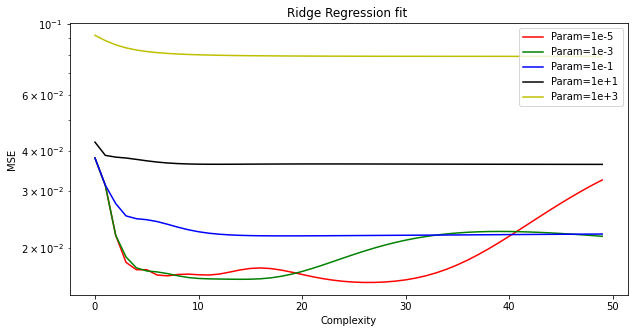

In [158]:
maxdegree=50
bias=np.zeros(maxdegree)
variance=np.zeros(maxdegree)
mse_train=np.zeros((maxdegree))
r2_train=np.zeros((maxdegree))
r2_test=np.zeros((maxdegree))
mse_test=np.zeros((maxdegree))
p1=np.arange(maxdegree)
stop = 4
folds=5
start=5
tot=start+stop+1        
val=np.logspace(-start,stop,num=tot)
mse=np.zeros((tot,maxdegree))
#fitting and bootstraping for a given hyper parameter values over variation in complexity
#loop over hyper parameter values
for j in range(tot):
    #loop over complexity
    for i in range(maxdegree):
    #bias[i],variance[i] = bootstrap(XY_train,XY_test,z_train,z_test,degree=i+1,alpha=0.1,n_bootstraps=400)
   
        model=Ridge(val[j])
        r2_train[i],mse_train[i],r2_test[i],mse_test[i]=score(XY_train,XY_test,z_train,z_test,degree=i+1,model=model)
        mse[j,i]=mse_test[i];
#plotting the MSE, Bias and the variance of the fit 
#plt.plot(p1,mse_train,'b-')
#for k in range (tot):
plt.plot(p1,mse[0,:],'r-',label='Param=1e-5')
plt.plot(p1,mse[2,:],'g-',label='Param=1e-3')
plt.plot(p1,mse[4,:],'b-',label='Param=1e-1')
plt.plot(p1,mse[6,:],'k-',label='Param=1e+1')
plt.plot(p1,mse[8,:],'y-',label='Param=1e+3')
#plt.plot(p1,bias, 'k-')
#plt.plot(p1,variance, 'g-')
plt.yscale('log')
plt.xlabel(r'Complexity')
plt.ylabel(r'MSE')
plt.title(r'Ridge Regression fit ')
plt.legend()
plt.show()

In [93]:
val

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])

In [107]:
#check effect of cross validation on Ridge regression
stop = 8
folds=5
start=8
tot=start+stop+1        
val=np.logspace(-start,stop,num=tot)
trainLR=np.zeros((tot))
testLR=np.zeros((tot))
maxFolds = 10
c1=np.arange(maxdegree)
k1 = np.zeros((maxFolds,tot))
for k in range(maxFolds-5):
    kfold = KFold(n_splits = k+5)
    for i in range(tot):
            c1[i]=i
            polyreg=PolynomialFeatures(5)
            model=Ridge(val[i])
            XY1_train=polyreg.fit_transform(XY_train)
            LR_estimated_mse_folds = cross_val_score(model, XY1_train, z_train, scoring='neg_mean_squared_error', cv=kfold)
            testLR[i]=np.mean(-LR_estimated_mse_folds)
            k1[k,i] = testLR[i]
    
print(k1)  

[[0.01264599 0.01264473 0.0126338  0.01262142 0.01317629 0.01433132
  0.01744553 0.02028012 0.0252968  0.03311602 0.04768779 0.07536333
  0.08404986 0.08508845 0.08519431 0.08520492 0.08520598]
 [0.01260612 0.01260425 0.01258746 0.01253697 0.01307887 0.01447985
  0.01762407 0.02030922 0.02515187 0.03282872 0.04732017 0.07498293
  0.08390222 0.08497581 0.08508532 0.08509629 0.08509739]
 [0.01260881 0.01260726 0.01259353 0.01256071 0.01313283 0.01449581
  0.01762076 0.02034264 0.02525757 0.03287679 0.04701885 0.07459431
  0.08371024 0.08481345 0.08492605 0.08493734 0.08493846]
 [0.01254721 0.01254585 0.01253371 0.01250494 0.0130493  0.01433677
  0.01743134 0.0202193  0.02516159 0.03281431 0.04686265 0.07437956
  0.08365129 0.08477855 0.08489367 0.0849052  0.08490636]
 [0.01266569 0.01266429 0.01265187 0.0126248  0.01323539 0.0146984
  0.01786709 0.02053877 0.02524877 0.0328023  0.04678666 0.07425103
  0.08366605 0.08481556 0.084933   0.08494477 0.08494595]
 [0.         0.         0.     

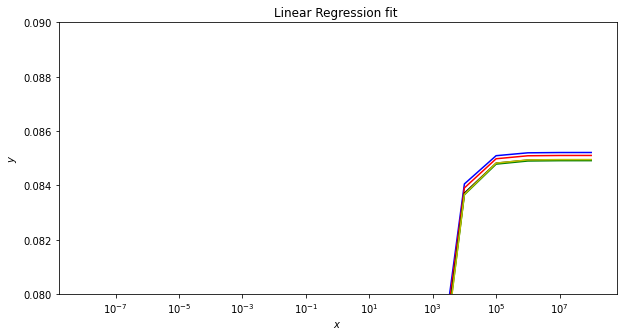

In [111]:
plt.plot(val,k1[0,:],'b-')
plt.plot(val,k1[1,:], 'r-')
plt.plot(val,k1[2,:], 'k-')
plt.plot(val,k1[3,:], 'g-')
plt.plot(val,k1[4,:], 'y-')
#plt.axis([0,30,0, 0.9])
plt.xscale('log')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Linear Regression fit ')
plt.ylim(0.08, 0.09)
plt.show()